# Introduction to Bayesian Optimization
**Drew Gjerstad**  

_Bayesian Optimization Series_  
[github.com/drewgjerstad/bayesian-optimization](https://github.com/drewgjerstad/bayesian-optimization)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Contents
 * [Introduction](#introduction)
 * [Motivation](#motivation)
     - [Theoretical Motivation](#theoretical-motivation)
     - [Applications](#applications)
 * [Optimization Foundations](#optimization-foundations)
 * [Bayesian Foundations](#bayesian-foundations)
 * [The Bayesian Approach](#the-bayesian-approach)
 * [Bayesian Optimization Workflow](#bayesian-optimization-workflow)
 * [References](#references)

## Introduction
**Bayesian optimization** refers to an optimization approach that uses Bayesian
inference to guide the optimizer to make "better" decisions based on
_uncertainty_. One attractive feature of this approach is its _unparalleled_
sample efficiency (more on this later). Additionally, _uncertainty_ is inherent
in all optimization decisions but we can use the Bayesian approach to tackle it,
and often overcome it, in a strategic manner.

The goal of this notebook is to introduce you to Bayesian optimization from a
high-level perspective as well as introduce you to the "Bayesian optimization
workflow" and the components involved. Additional notebooks that cover these
topics in more depth can be found within the
[`bayesian-optimization`](https://github.com/drewgjerstad/bayesian-optimization)
repo. We begin with the theoretical motivation for Bayesian optimization and an
overview of its applications.

## Motivation

### Theoretical Motivation
Before we explore the applications of Bayesian optimization, we must consider
the theoretical motivation for such an approach. The theoretical motivation
typically stems from the form or type of _objective_ (the "function" we are
aiming to optimize).

 * **Black-box objective functions** are functions that we can only interact
   with via its inputs and outputs meaning typical methods do not work. However,
   we can usually approximate such an objective and use Bayesian optimization to
   manage the uncertainty.

 * **Expensive-to-evaluate objective functions** are functions that require
   significant computation effort to obtain their output. However, once again,
   we can approximate and model these efficiently using the Bayesian approach.

 * More generally, this approach is very useful when the objectives lack
   analytical evaluation (or, if analytical evaluation is expensive).

 * In some spaces such as discrete or combinatorial, the objectives may not have
   efficient gradients (if they exist) and so classical gradient-based
   optimization methods are incompatible.

There are additional supporting points to the theoretical motivation for
Bayesian optimization but these seem to be the most common, especially with
regard to the form and properties of the objective.

### Applications
The application potential of Bayesian optimization can be seen across several
critical domains, especially those attempting to accelerate finding solutions to
real-world scientific and engineering problems. Some of these applications
include:
 * Drug Discovery
 * Molecule/Protein Discovery
 * Materials Design
 * AutoML (i.e., hyperparameter tuning)
 * Engineering Decisions
 * Many more...

The images and diagrams below should help you form an idea of how Bayesian
optimization fits into some of these applications. Note that this is by no means
an exhaustive list nor should you worry too much about some of the contextual
details of the specific applications shown. This is merely to provide real-world
motivation for this optimization approach.

#### Application: Drug Discovery
The image below provides an example of optimization applied to a chemical
process problem (common in drug discovery). Don't worry about the details
regarding the formulation of the problem itself but rather consider the fact
that running chemical synthesis experiments require two things: _time_ and
_money_. Therefore, scientists want to accelerate finding optimal solutions or
in this case, optimal chemical processes/reactions.

In the bottom right of the image, four common (classical) approaches to this
optimization problem are shown. However, these approaches are likely expensive
(as mentioned previously). Therefore, the alternative approach, Bayesian
optimization, is shown in the bottom left of the image. Bayesian optimization
can use data from previous experiments to locate points (samples) that may
optimize the unknown objective, while accounting for uncertainty in the model.
These points will typically then be used to plan the next experiments since they
represent samples of high utility. In this context, high utility means the point
could be useful in optimizing the reaction parameter.

<img src="graphics/01-introduction/applications/drug-discovery.png"
     alt="Drug Discovery Application" width="600"/>

Figure from _Bayesian optimization as a tool for chemical synthesis_ by Shields
et al. (2021)

#### Application: Molecule/Protein Discovery
In the field of molecule and protein design, there are similar considerations to
the ones in the previous application: experiments are costly. In the diagram
below, the integration of Bayesian optimization with experimentation is shown.
Scientists typically synthesize and test several different formulations to build
a dataset. This dataset is used to help model the unknown objective and can be
used to suggest new formulations. As new formulations are synthesized and
tested, they are added to the dataset so as to inform the model and optimizer of
formulations to suggest next.

<img src="graphics/01-introduction/applications/molecule-protein-discovery.png"
     alt="Molecule/Protein Discovery Application" width=600/>

Figure from _Sequential closed-loop Bayesian optimization as a guide for_
_organic molecular metallophotocatalyst formulation discovery_ by Li et al.
(2024)

#### Application: Materials Discovery
The diagram below is very similar to the one for molecule/protein discovery
except now it is demonstrating some additional specifics for materials design
and discovery. Once again, the initial dataset is used to model the likely
unknown objective to inform design exploration and then the results from the
design exploration are used to augment the dataset. It appears that in this
loop, the researchers are also using the experiments to help calibrate a
simulation of designs, another application of Bayesian optimization.

<img src="graphics/01-introduction/applications/materials-design.jpg"
     alt="Materials Discovery Application" width=600/>

Figure from _Bayesian optimization for Materials Design with Mixed_
_Quantitative and Qualitative Variables_ by Zhang et al. (2020)

#### Application: AutoML
AutoML is the process of automating the machine learning workflow and often
includes tuning models' hyperparameters. Bayesian optimization can be used to
tune hyperparameters more efficiently by identifying the next hyperparameters to
test based on the current model and its quantified uncertainty. The workflow
below shows how hyperparameters for a neural network are tuned using Bayesian
optimization (using a Gaussian process as a surrogate model).

<img src="graphics/01-introduction/applications/automl.png"
     alt="AutoML Application" width=600/>

Figure from _Achieve Bayesian optimization for tuning hyperparameters_ by Edward
Ortiz on _Medium_ (2020)

#### Application: Engineering Decisions
Bayesian optimization is also useful for making engineering decisions such as
design choices to optimize hardware performance. In the diagram below, Bayesian
optimization is being used to calibrate a particle accelerator in a similar
manner as some of the previous examples. The "operator" inputs the target beam
parameters while a camera inputs the observed beam parameters. Then, Bayesian
optimization determines the changes (next set of beam parameters) to hopefully
improve the calibration of the particle accelerator.

<img src="graphics/01-introduction/applications/engineering-decisions.png"
     alt="Engineering Decisions Application" width=600/>

Figure from _Reinforcement learning-trained optimizers and Bayesian_
_optimization for online particle accelerator tuning_ by Kaiser et al. (2024)

## Optimization Foundations

In this section, we will examine the foundations of optimization to understand
the ideas and methods that Bayesian optimization builds on. This will include
formalizing optimization, objective functions, observation models, some common
optimization policies, termination policies, and a diagram of the optimization
process. For a more thorough examination of numerical optimization, see Nocedal
and Wright's _Numerical Optimization_ (Springer Series in Operations Research).

**Optimization** is a process and field of study that aims to efficiently locate
the optimal objective value and/or its location from the search domain and its
corresponding objective values.

### Formalization of Optimization

Let's first formalize a typical optimization problem. This formulation is a
simple and flexible one for global optimization and is not inherently Bayesian.
Additionally, it is also formulating a _continuous_ optimization problem but
there exists other "types" of optimization other than just continuous.

\begin{equation*}
    x^* \in \argmax_{x \in \mathcal{X}} f(x)
    \hspace{36pt}
    f^* = \max_{x \in \mathcal{X}} f(x) = f(x^*)
\end{equation*}
where $f:\mathcal{X}\rightarrow\mathbb{R}$ is a real-valued _objective function_
on some domain $\mathcal{X}$, $x^*$ is the point that obtains the global maximum
value $f^*$. Note that the $\max$ versus $\min$ is arbitrary and depends on the
specific problem.

_Black-box optimization_ arises from the fact that we do not need to have an
explicit objective function $f$ but rather only some information about the
objective at identified points.

The code below creates a plot showing a objective function and points showing
the _optima_. Optima are the points that either maximize or minimize the
objective function.

\begin{equation*}
    f(x) = 10\sin(0.2x)\cos(0.1x) + \sin(0.5x) + 0.05x
\end{equation*}

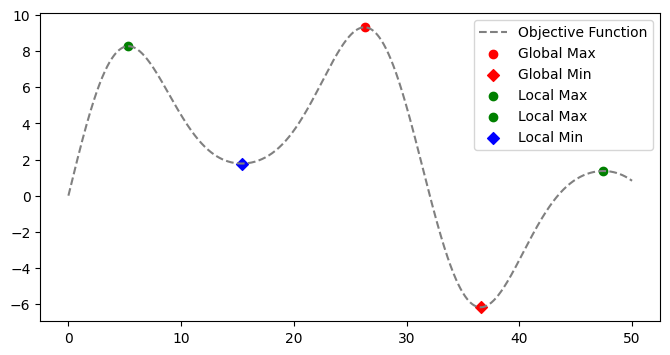

In [ ]:
# Plot Objective Function with Optima Labeled

def objective(x:np.array)->np.array:
    return (np.sin(0.2 * x) * np.cos(0.1 * x) * 10 +
            np.sin(0.5 * x) + 0.05 * x)

x = np.linspace(0, 50, 1000)
y = objective(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y, label="Objective Function", c="gray", linestyle="--")
plt.scatter(x[np.argmax(y)], np.max(y), label="Global Max", c="r")
plt.scatter(x[np.argmin(y)], np.min(y), label="Global Min", c="r", marker="D")
plt.scatter(x[np.argmax(y[:200])], np.max(y[:200]), label="Local Max",
            c="g", marker="o")
plt.scatter(x[np.argmax(y[800:]) + 800], np.max(y[800:]), label="Local Max",
            c="g", marker="o")
plt.scatter(x[np.argmin(y[200:400]) + 200], np.min(y[200:400]),
            label="Local Min", c="b", marker="D")
plt.legend()
plt.show()

### Objective Functions

### Observation Models

### Optimization Policies

### Termination Policies

### Diagram of the Optimization Process

## Bayesian Foundations

## The Bayesian Approach

## Bayesian Optimization Workflow

### Surrogate Models

### Acquisition Functions

### Acquisition Function Optimizers

## References